<a href="https://colab.research.google.com/github/budhiacharya/AI-Lesson/blob/main/Assign_10_AI.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# 1. Dataset Selection and Preprocessing

In [ ]:
import pandas as pd
df_raw = pd.read_csv('amazon_alexa.tsv', sep='\t')
df = df_raw.rename(columns={"verified_reviews": "text", "feedback": "label"})[["text", "label"]].dropna()
df.head()

,text,label
0,Love my Echo!,1
1,Loved it!,1
2,"Sometimes while playing a game, you can answer...",1
3,I have had a lot of fun with this thing. My 4 ...,1
4,Music,1


In [ ]:
# ---- Basic setup ----
!pip -q install pandas numpy scikit-learn matplotlib seaborn

import pandas as pd, numpy as np
import matplotlib.pyplot as plt, seaborn as sns
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler, OneHotEncoder
from sklearn.compose import ColumnTransformer
from sklearn.pipeline import Pipeline

In [ ]:
# Basic cleaning
df = df.dropna(subset=["text", "label"]).copy()
df["text"] = df["text"].astype(str).str.strip()
df["label"] = df["label"].astype(int)

In [ ]:
cat_cols = [c for c in df.columns if c not in ["text","label"] and df[c].dtype == "object"]
num_cols = [c for c in df.columns if c not in ["text","label"] and pd.api.types.is_numeric_dtype(df[c])]

In [ ]:
# Simple imputation for missing (if any)
for c in cat_cols: df[c] = df[c].fillna("Unknown")
for c in num_cols: df[c] = df[c].fillna(df[c].median())

In [ ]:
print(df.head())
print("cat_cols:", cat_cols, "num_cols:", num_cols)

                                                text  label
0                                      Love my Echo!      1
1                                          Loved it!      1
2  Sometimes while playing a game, you can answer...      1
3  I have had a lot of fun with this thing. My 4 ...      1
4                                              Music      1
cat_cols: [] num_cols: []


# 2. Feature Engineering (BoW, TF-IDF, Word2Vec) and Embedding Visualization

In [ ]:
!pip -q install gensim

from sklearn.feature_extraction.text import CountVectorizer, TfidfVectorizer
from gensim.models import Word2Vec
from sklearn.manifold import TSNE
from sklearn.decomposition import PCA

In [ ]:
# Train/test split up front so we avoid leakage
X_train_text, X_test_text, y_train, y_test = train_test_split(
    df["text"].values, df["label"].values, test_size=0.2, random_state=42, stratify=df["label"])

In [ ]:
# --- Bag of Words ---
bow = CountVectorizer(max_features=5000, stop_words="english")
Xtr_bow = bow.fit_transform(X_train_text)
Xte_bow = bow.transform(X_test_text)

In [ ]:
# --- TF-IDF ---
tfidf = TfidfVectorizer(max_features=5000, stop_words="english", ngram_range=(1,2))
Xtr_tfidf = tfidf.fit_transform(X_train_text)
Xte_tfidf = tfidf.transform(X_test_text)

In [ ]:
# --- Word2Vec (train on your corpus) ---
tokens = [t.split() for t in df["text"].astype(str)]
w2v = Word2Vec(sentences=tokens, vector_size=100, window=5, min_count=5, workers=4, sg=1)
print("Vocab size:", len(w2v.wv))

Vocab size: 1621


In [ ]:
# Visualize word embeddings (pick top-N frequent words in vocab)
top_words = list(w2v.wv.key_to_index.keys())[:300]  # adjust if you want
vecs = np.vstack([w2v.wv[w] for w in top_words])

In [ ]:
# Dimensionality reduction (PCA -> t-SNE faster)
pca_2 = PCA(n_components=30, random_state=42).fit_transform(vecs)
tsne_2 = TSNE(n_components=2, learning_rate="auto", init="random", perplexity=30, random_state=42).fit_transform(pca_2)

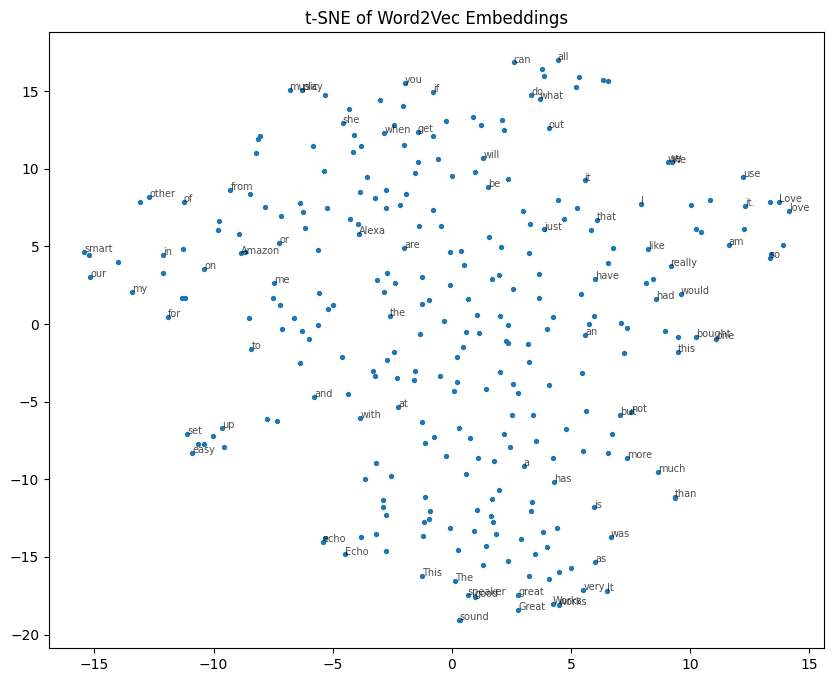

In [ ]:
plt.figure(figsize=(10,8))
plt.scatter(tsne_2[:,0], tsne_2[:,1], s=8)
for i, w in enumerate(top_words[:80]):  # label a few
    plt.annotate(w, (tsne_2[i,0], tsne_2[i,1]), fontsize=7, alpha=0.7)
plt.title("t-SNE of Word2Vec Embeddings")
plt.show()

# 3. Text Classification with Traditional Models (LR & SVM) + Grid Search

In [ ]:
from sklearn.linear_model import LogisticRegression
from sklearn.svm import LinearSVC
from sklearn.model_selection import GridSearchCV
from sklearn.metrics import classification_report, confusion_matrix, roc_auc_score

In [ ]:

# Evaluate function
def eval_model(name, y_true, y_pred, y_proba=None):
    print(f"\n=== {name} ===")
    print(classification_report(y_true, y_pred, digits=4))
    cm = confusion_matrix(y_true, y_pred)
    sns.heatmap(cm, annot=True, fmt="d", cmap="Blues")
    plt.title(f"{name} - Confusion Matrix")
    plt.xlabel("Pred"); plt.ylabel("True")
    plt.show()
    if y_proba is not None:
        try:
            auc = roc_auc_score(y_true, y_proba)
            print(f"ROC-AUC: {auc:.4f}")
        except:
            pass

Best params (LR): {'C': 3}

=== LogReg (TF-IDF) ===
              precision    recall  f1-score   support

           0     0.7143    0.0980    0.1724        51
           1     0.9262    0.9965    0.9601       579

    accuracy                         0.9238       630
   macro avg     0.8202    0.5473    0.5662       630
weighted avg     0.9090    0.9238    0.8963       630



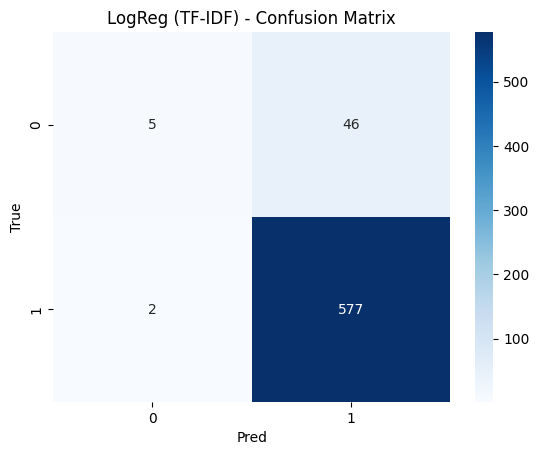

ROC-AUC: 0.9485


In [ ]:
# Logistic Regression on TF-IDF with grid search
logit = LogisticRegression(max_iter=200, n_jobs=-1)
grid_logit = GridSearchCV(
    logit,
    param_grid={"C":[0.1,1,3]},
    scoring="f1",
    cv=3,
    n_jobs=-1,
    verbose=0
)
grid_logit.fit(Xtr_tfidf, y_train)
pred_lg = grid_logit.predict(Xte_tfidf)
proba_lg = grid_logit.predict_proba(Xte_tfidf)[:,1]
print("Best params (LR):", grid_logit.best_params_)
eval_model("LogReg (TF-IDF)", y_test, pred_lg, proba_lg)

Best params (SVM): {'C': 0.1}

=== Linear SVM (BoW) ===
              precision    recall  f1-score   support

           0     0.6923    0.3529    0.4675        51
           1     0.9454    0.9862    0.9653       579

    accuracy                         0.9349       630
   macro avg     0.8188    0.6696    0.7164       630
weighted avg     0.9249    0.9349    0.9250       630



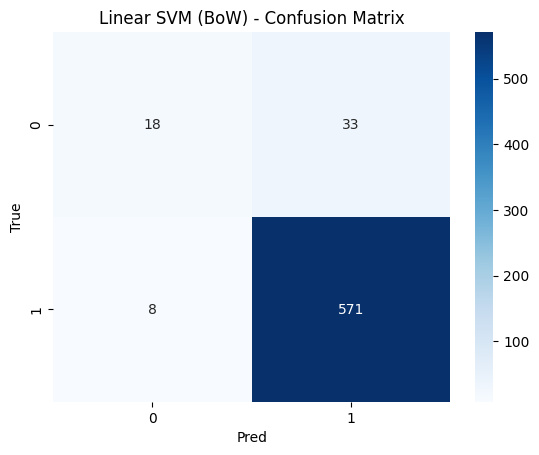

In [ ]:
# Linear SVM on BoW with grid search
svm = LinearSVC()
grid_svm = GridSearchCV(
    svm,
    param_grid={"C":[0.1,1,3]},
    scoring="f1",
    cv=3,
    n_jobs=-1,
    verbose=0)
grid_svm.fit(Xtr_bow, y_train)
pred_svm = grid_svm.predict(Xte_bow)
print("Best params (SVM):", grid_svm.best_params_)
# LinearSVC has no predict_proba; skip ROC here
eval_model("Linear SVM (BoW)", y_test, pred_svm)

# 4) Sentiment Analysis Using a Large Language Model (BERT fine-tuning)

In [ ]:
import numpy as np
from datasets import Dataset
from transformers import AutoTokenizer, DataCollatorWithPadding
from transformers import AutoModelForSequenceClassification, TrainingArguments, Trainer
from sklearn.metrics import accuracy_score, precision_recall_fscore_support, roc_auc_score

In [ ]:
!pip install --upgrade transformers accelerate --quiet

In [ ]:
from transformers import TrainingArguments, Trainer

In [ ]:
# Build Hugging Face Dataset objects
train_ds = Dataset.from_dict({"text": X_train_text.tolist(), "label": y_train.tolist()})
test_ds  = Dataset.from_dict({"text": X_test_text.tolist(),  "label": y_test.tolist()})

model_ckpt = "distilbert-base-uncased"
tok = AutoTokenizer.from_pretrained(model_ckpt)

def tokenize(batch):
    return tok(batch["text"], truncation=True, padding=False, max_length=256)

train_tok = train_ds.map(tokenize, batched=True)
test_tok  = test_ds.map(tokenize, batched=True)

data_collator = DataCollatorWithPadding(tokenizer=tok)

model = AutoModelForSequenceClassification.from_pretrained(model_ckpt, num_labels=2)

def compute_metrics(eval_pred):
    logits, labels = eval_pred
    preds = np.argmax(logits, axis=1)
    acc = accuracy_score(labels, preds)
    p, r, f1, _ = precision_recall_fscore_support(labels, preds, average="binary", zero_division=0)
    # ROC-AUC needs probabilities:
    prob1 = (logits - logits.max(axis=1, keepdims=True))  # stabilize softmax
    prob1 = np.exp(prob1); prob1 = prob1/ prob1.sum(axis=1, keepdims=True)
    auc = roc_auc_score(labels, prob1[:,1])
    return {"accuracy": acc, "precision": p, "recall": r, "f1": f1, "roc_auc": auc}

args = TrainingArguments(
    output_dir="./bert_out",
    logging_steps=50,
    evaluation_strategy="epoch",
    save_strategy="no",
    num_train_epochs=1,        # keep small for demo; use 2-3+ for better results
    per_device_train_batch_size=16,
    per_device_eval_batch_size=32,
    learning_rate=2e-5,
    weight_decay=0.01,
    report_to="none"
)

trainer = Trainer(
    model=model,
    args=args,
    train_dataset=train_tok,
    eval_dataset=test_tok,
    tokenizer=tok,
    data_collator=data_collator,
    compute_metrics=compute_metrics
)

trainer.train()
metrics = trainer.evaluate()
metrics


   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 511.6/511.6 kB 5.4 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 47.7/47.7 MB 16.7 MB/s eta 0:00:00


Map:   0%|          | 0/2519 [00:00<?, ? examples/s]

Map:   0%|          | 0/630 [00:00<?, ? examples/s]

Some weights of DistilBertForSequenceClassification were not initialized from the model checkpoint at distilbert-base-uncased and are newly initialized: ['classifier.bias', 'classifier.weight', 'pre_classifier.bias', 'pre_classifier.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.


TypeError: TrainingArguments.__init__() got an unexpected keyword argument 'evaluation_strategy'

# 5) Model Evaluation (Accuracy/Precision/Recall/F1/ROC) + ROC Curves

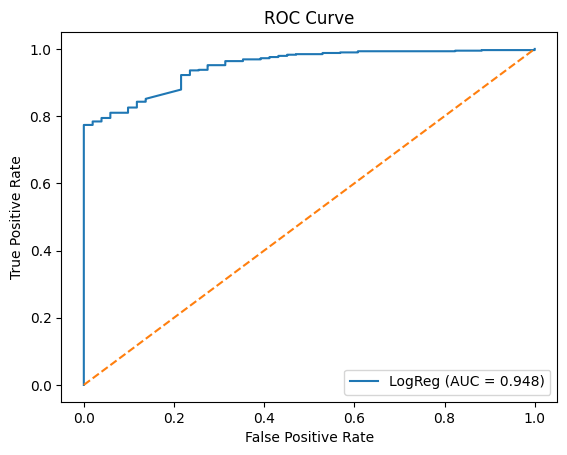

/usr/local/lib/python3.12/dist-packages/torch/utils/data/dataloader.py:666: UserWarning: 'pin_memory' argument is set as true but no accelerator is found, then device pinned memory won't be used.
  "then device pinned memory won't be used."


Step,Training Loss


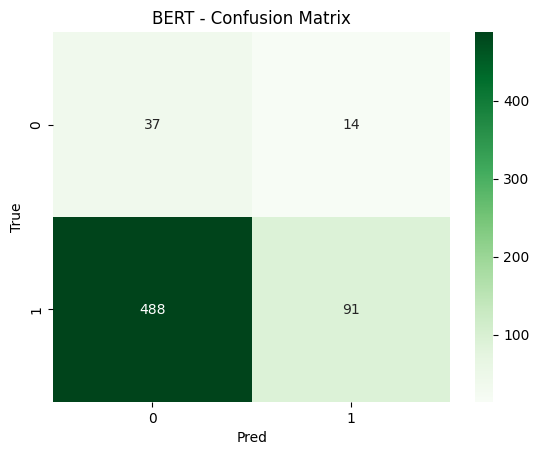

In [ ]:
from sklearn.metrics import roc_curve, auc

# Logistic Regression ROC curve (we already computed probabilities)
fpr, tpr, _ = roc_curve(y_test, proba_lg)
roc_auc = auc(fpr, tpr)

plt.figure()
plt.plot(fpr, tpr, label=f"LogReg (AUC = {roc_auc:.3f})")
plt.plot([0,1], [0,1], linestyle="--")
plt.xlabel("False Positive Rate"); plt.ylabel("True Positive Rate")
plt.title("ROC Curve")
plt.legend()
plt.show()

# Confusion matrices already plotted above for LR & SVM
# For BERT, get raw preds and plot CM similarly:
pred_out = trainer.predict(test_tok)
bert_preds = pred_out.predictions.argmax(1)

cm_bert = confusion_matrix(y_test, bert_preds)
sns.heatmap(cm_bert, annot=True, fmt="d", cmap="Greens")
plt.title("BERT - Confusion Matrix")
plt.xlabel("Pred"); plt.ylabel("True")
plt.show()
